In [1]:
import os
import requests
import pandas as pd
import numpy as np
#from annotationframeworkclient import imagery
#from annotationframeworkclient.jsonservice import JSONService
#from annotationframeworkclient import imagery
import cloudvolume
from caveclient import CAVEclient
import nglui
from statistics import mean
import matplotlib.pyplot as plt

client = CAVEclient('minnie65_phase3_v1')
#client = CAVEclient('minnie65_public')
client.info.get_datastack_info()

{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1',
 'skeleton_source': 'precomputed://middleauth+https://minnie.microns-daf.com/skeletoncache/api/v1/minnie65_phase3_v1/precomputed/skeleton',
 'analysis_database': None,
 'viewer_site': 'https://neuroglancer.neuvue.io/',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_neuron_svm',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the first version of Minnie that has proofreading enabled. Was first enabled on June 24, 2020. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 

In [3]:
# MAIN
#IMPORT SYNAPSE TABLE

pd.options.display.max_rows = None
pd.options.display.max_columns = None

synapse_table = pd.read_feather("ET_Column_synapse_table_revision.feather")

In [4]:
# check duplicate entries 
duplicates = synapse_table[synapse_table['synapse_id'].duplicated(keep=False)]

print("Duplicate entries:")
print(duplicates.synapse_id.unique())

# Remove duplicate rows 

print("original synapse table size")
print(synapse_table.shape)

synapse_table = synapse_table.drop_duplicates(subset='synapse_id')

print(" synapse table size without duplicates")
print(synapse_table.shape)


Duplicate entries:
[]
original synapse table size
(3814, 35)
 synapse table size without duplicates
(3814, 35)


In [5]:
# MAIN
#Merge postsynaptic structure information onto synapse table.

post_struture_df  = client.materialize.query_table("vortex_compartment_targets")
post_struture_df = post_struture_df.rename(columns={"target_id": "synapse_id"})

#merge manual labels

synapse_table = (
    synapse_table.merge(
        post_struture_df[["synapse_id", "tag"]].rename(
            columns={"tag": "synapse_structure"}
        ),
        on='synapse_id',
        how="left",
    )
)

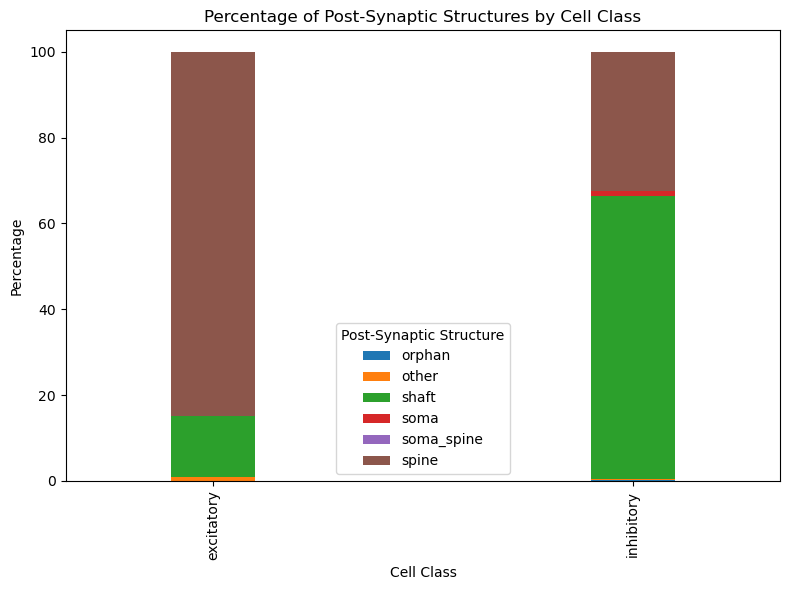

synapse_structure,orphan,other,shaft,soma,soma_spine,spine
consensus_class,,,,,,
excitatory,1,10,180,0,0,1080
inhibitory,5,4,1547,26,3,758


In [6]:
#Class Percentages

import pandas as pd
import matplotlib.pyplot as plt

# Calculate counts and normalize them to percentages
grouped = synapse_table.groupby(['consensus_class', 'synapse_structure']).size().unstack(fill_value=0)
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting

fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axes
percentages.plot(kind='bar', stacked=True, ax=ax, width=0.2)

ax.set_title('Percentage of Post-Synaptic Structures by Cell Class')
ax.set_ylabel('Percentage')
ax.set_xlabel('Cell Class')
ax.legend(title='Post-Synaptic Structure')

plt.tight_layout()
fig.savefig('Extended_Fig13_A_Synaptic_Structure_Class_revision.eps', bbox_inches='tight')

plt.show()

grouped

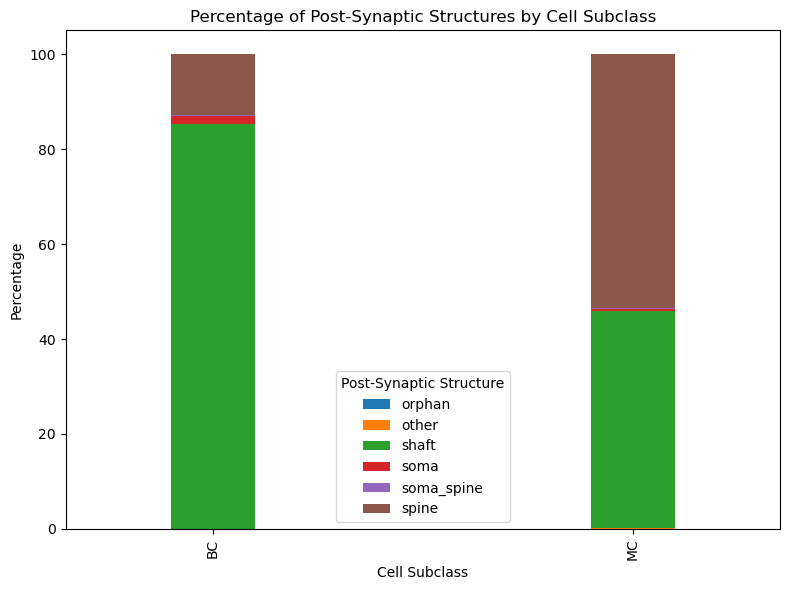

synapse_structure,orphan,other,shaft,soma,soma_spine,spine
consensus_subclass,,,,,,
BC,0,0,1010,21,1,153
MC,0,3,467,5,2,549


In [7]:
#Subclass Percentages

import pandas as pd
import matplotlib.pyplot as plt

# Calculate counts and normalize them to percentages
grouped = synapse_table.groupby(['consensus_subclass', 'synapse_structure']).size().unstack(fill_value=0)
grouped = grouped.loc[['BC', 'MC']]
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting

fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axes
percentages.plot(kind='bar', stacked=True, ax = ax, width=0.2)

ax.set_title('Percentage of Post-Synaptic Structures by Cell Subclass')
ax.set_ylabel('Percentage')
ax.set_xlabel('Cell Subclass')
ax.legend(title='Post-Synaptic Structure')

plt.tight_layout()
fig.savefig('Extended_Fig13_B_Synaptic_Structure_Subclass_revision.eps', bbox_inches='tight')

plt.show()

grouped

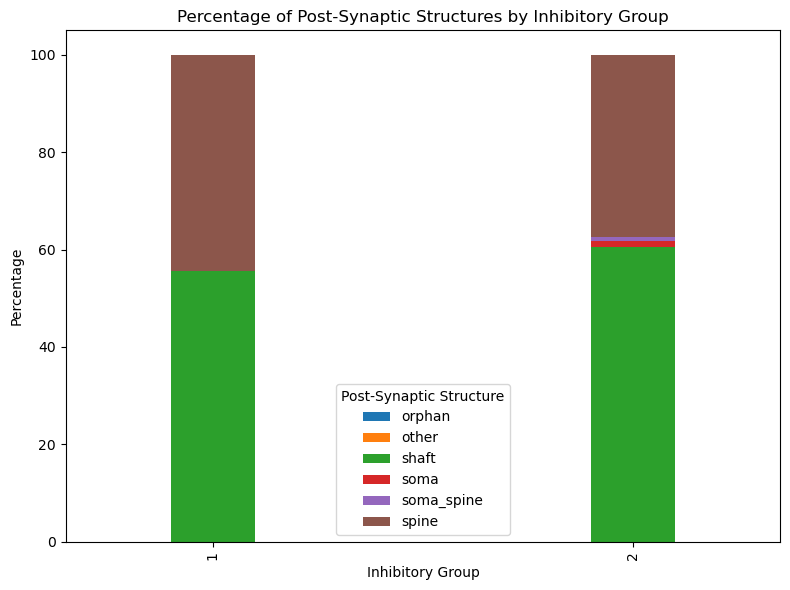

Number of entries with value 1: 115
Number of entries with value 2: 422


synapse_structure,orphan,other,shaft,soma,soma_spine,spine
inhibitory_groups,,,,,,
1,0,0,64,0,0,51
2,0,0,255,6,3,158


In [8]:
#Group 1 and 2 Percentages

import pandas as pd
import matplotlib.pyplot as plt

# Calculate counts and normalize them to percentages
grouped = synapse_table.groupby(['inhibitory_groups', 'synapse_structure']).size().unstack(fill_value=0)
grouped = grouped.loc[[1, 2]]
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting

fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axes
percentages.plot(kind='bar', stacked=True, ax = ax, width=0.2)

ax.set_title('Percentage of Post-Synaptic Structures by Inhibitory Group')
ax.set_ylabel('Percentage')
ax.set_xlabel('Inhibitory Group')
ax.legend(title='Post-Synaptic Structure')

plt.tight_layout()
fig.savefig('Extended_Fig13_C_Synaptic_Structure_Groups_revision.eps', bbox_inches='tight')

plt.show()

count = (synapse_table['inhibitory_groups'] == 1).sum()
print(f"Number of entries with value 1: {count}")

count = (synapse_table['inhibitory_groups'] == 2).sum()
print(f"Number of entries with value 2: {count}")

grouped